<h2><center> Image Classification of Birds using the iNaturalist Dataset</center></h2>
<h3><center>Springboard | Capstone 2: In-Depth Analysis/Modeling: Model 1 </center></h3>
<h4><center>By: Lauren Broussard</center></h4>

### MODEL 1.

For our first model, we'll create a simple neural network to see how it does. We'll add five hidden layers, and a flatten layer. Our first layer will include 32 nodes, and we'll use ReLU activation for each of our hidden layers.

First, we'll run some of our setup operations from our PreProcessing Notebook. In it, we do a number of set up steps like create our train, test, and validation sets, set up the number of epochs to run, and augment the orientation of our training and validation images. 

In [41]:
print("Pre-Processing & Set Up")
%run ./2.0_PreProcessing_SetUp.ipynb

Pre-Processing & Set Up
Total Images To Use: 2500

Number of Training Images:  1400
Number of Validation Images:  500
Number of Test Images:  600 

img_dir =  ../data/raw/
img_width, img_height =  128 128
batch_size =  128
no_epochs =  25
no_classes =  2 


Augment Images - Training
Found 1400 validated image filenames belonging to 2 classes.
CPU times: user 16.6 ms, sys: 5.51 ms, total: 22.1 ms
Wall time: 22.6 ms

Augment Images - Validation and Testing
Found 500 validated image filenames belonging to 2 classes.
CPU times: user 7.79 ms, sys: 1.97 ms, total: 9.75 ms
Wall time: 9.76 ms


#### Set Architecture

In [2]:
model1 = Sequential()

model1.add(Dense(32,activation = 'relu', input_shape = (img_width,img_height,3)))
model1.add(Dense(32, activation = 'relu'))
model1.add(Dense(32, activation = 'relu'))

model1.add(Flatten())
model1.add(Dense(32, activation = 'relu'))
model1.add(Dense(100, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))

#### Compile

In [3]:
%%time
# compile, and add metrics==['accuracy'] to keep track of diagnostics for each epoch
model1.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

CPU times: user 6.62 ms, sys: 506 µs, total: 7.13 ms
Wall time: 6.7 ms


#### Fit

In [4]:
%%time
model1_history = model1.fit(
    train_generator,
    steps_per_epoch= len(df_train) // batch_size,
    epochs=no_epochs,
    validation_data=valid_generator,
    validation_steps= len(df_val) // batch_size,
    callbacks = [early_stopping_monitor],
    verbose=2)

Epoch 1/25
10/10 - 23s - loss: 5.5398 - accuracy: 0.5307 - val_loss: 1.6903 - val_accuracy: 0.5339
Epoch 2/25
10/10 - 21s - loss: 1.1027 - accuracy: 0.5865 - val_loss: 0.6177 - val_accuracy: 0.7083
Epoch 3/25
10/10 - 22s - loss: 0.6110 - accuracy: 0.6871 - val_loss: 0.5601 - val_accuracy: 0.7188
Epoch 4/25
10/10 - 21s - loss: 0.5740 - accuracy: 0.6918 - val_loss: 0.6010 - val_accuracy: 0.6901
Epoch 5/25
10/10 - 22s - loss: 0.5682 - accuracy: 0.7044 - val_loss: 0.5716 - val_accuracy: 0.7188
Epoch 6/25
10/10 - 22s - loss: 0.5455 - accuracy: 0.7131 - val_loss: 0.5475 - val_accuracy: 0.7240
Epoch 7/25
10/10 - 23s - loss: 0.5302 - accuracy: 0.7225 - val_loss: 0.5447 - val_accuracy: 0.7266
Epoch 8/25
10/10 - 23s - loss: 0.5265 - accuracy: 0.7335 - val_loss: 0.5589 - val_accuracy: 0.7214
Epoch 9/25
10/10 - 23s - loss: 0.5311 - accuracy: 0.7327 - val_loss: 0.5799 - val_accuracy: 0.7031
Epoch 10/25
10/10 - 23s - loss: 0.4976 - accuracy: 0.7539 - val_loss: 0.5328 - val_accuracy: 0.7552
Epoch 11/

#### View Model Summaries

In [5]:
# view model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128, 128, 32)      128       
_________________________________________________________________
dense_1 (Dense)              (None, 128, 128, 32)      1056      
_________________________________________________________________
dense_2 (Dense)              (None, 128, 128, 32)      1056      
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                16777248  
_________________________________________________________________
dense_4 (Dense)              (None, 100)               3300      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1

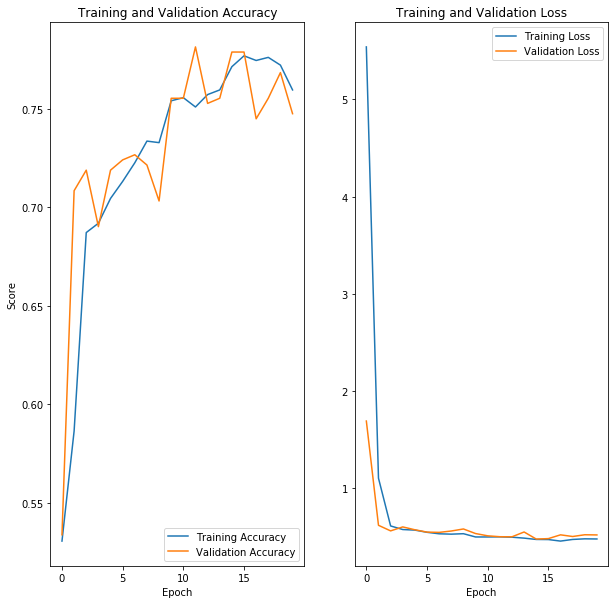

In [40]:
plot_accuracy_and_loss(model1_history) #called from 2.0_PreProcessing Notebook

#### Save Model

In [7]:
# save model
file_name = 'model1.h5'
model1.save('../models/{}'.format(file_name))

----

#### Predict

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(
                    dataframe=df_test,
                    directory=img_dir,
                    x_col="file_name",
                    y_col="is_bird",
                    batch_size=batch_size,
                    class_mode="binary",    
                    target_size=(img_height,img_width))

Found 600 validated image filenames belonging to 2 classes.


### RESULTS & VISUALIZATIONS

In [25]:
%%time

# make predictions on model1
y_pred = model1.predict_classes(test_generator)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Not Bird', 'Bird']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[129 172]
 [114 185]]
Classification Report
              precision    recall  f1-score   support

    Not Bird       0.53      0.43      0.47       301
        Bird       0.52      0.62      0.56       299

    accuracy                           0.52       600
   macro avg       0.52      0.52      0.52       600
weighted avg       0.52      0.52      0.52       600

CPU times: user 12.3 s, sys: 4.4 s, total: 16.7 s
Wall time: 6.73 s


In [2]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

_ = plt.plot([0, 1], [0, 1], 'k--')
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_generator.classes, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

_ = plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

NameError: name 'plt' is not defined

----

This model performs about as well as chance. 

In [ ]:
%load_ext watermark
%watermark -a "Lab 2.0" -d -t -v -p numpy,pandas,tensorflow,keras